# Exploring the data
In this notebook, we will explore the gathered data to understand any biases in class distributions, differences in point density, and other factors that might impact the architecture of the network.

## Step 1 gather the data from the JSON file

In [1]:
import json

with open("./fsg_accel_2024_08_16-11_06_03_recovered_filtered_0_labels.json", "r") as file:
    data_accel = json.load(file)


In [2]:
with open("skidpad_2025-08-06-17_26_12_merged_filtered_0_labels.json", "r") as file:
    data_skidpad = json.load(file)

## mapping of labels to classes
Below is a dictionary that maps the class labels to their corresponding names

In [3]:
label_to_type = {
    1: "Yellow",
    2: "Blue",
    3: "Orange",
    255: "False Positive"
}

# Step 2: compare number of frames per mission

In [4]:
frames_accel = data_accel.keys()
frames_skidpad = data_skidpad.keys()

print(f"Number of frames for acceleration mission: {len(frames_accel)}")
print(f"Number of frames for skipdad mission:      {len(frames_skidpad)}")

Number of frames for acceleration mission: 15
Number of frames for skipdad mission:      62


As we can see there is a significant difference in the number of cones between the acceleration mission and the skidpad mission. This was a conscious choice based on the inherent complexity of both missions. In the acceleration event, the cones are spread evenly and 5ms apart without any occlusion, in the skidpad mission there is a lot of occlusion especially at the timing lines. 

Additionally, we also switch from a left to a right circle in the skidpad where we therefore also turn while recording the scans make the scenes more complex and better suited for training data. 

# Step 3: gather total number of cones


In [5]:
clusters_accel_per_frame = [data_accel[x]["clusters"] for x in frames_accel]
clusters_accel = [ clusters_accel_per_frame[i][j] for i in range(len(clusters_accel_per_frame)) for j in range(len(clusters_accel_per_frame[i]))]

print(len(clusters_accel))

379


In [6]:
clusters_skidpad_per_frame = [data_skidpad[x]["clusters"] for x in frames_skidpad]
clusters_skidpad = [clusters_skidpad_per_frame[i][j] for i in range(len(clusters_skidpad_per_frame)) for j in range(len(clusters_skidpad_per_frame[i]))]

print(len(clusters_skidpad))

1775


In total we have labeled $379 + 1775 = 2154$ cone proposals. Now let's compute the number of cones per class. 

# Step 4: number of cones per class
We start by merging the lists, since the clusters are agnostic per mission and the intent is to use the same model for each mission.

In [7]:
clusters = clusters_accel + clusters_skidpad

In [8]:
# lets create a list of the labels
labels = list(map(lambda x: x["label"], clusters))

In [9]:
# Let's use the counter for each class label
from collections import Counter

c = Counter(labels)
print(c)

Counter({255: 1206, 2: 379, 1: 367, 3: 201, 0: 1})


In total we have the following counts per class label:
- `False Positives`: 1206,
- `Blue cones`: 379,
- `Yellow cones`: 367
- `orange cones`: 201

As we can see we have a lot more false positives compared to any of the types. This is again the consequence of a design choice in the pre-processing pipeline. In this pipeline, we explicitly set low thresholds s.t. as many cones will be proposed as cone proposals. However as always in Computer Science, this comes at a cost, namely a lot of false positives are also cone proposals. This is also a consequence of the LiDAR inclination on the vehicle. The LiDAR is angled heavily downward causing nearby objects to have over a 1000 points and objects at a further distance only 10/9. In the ideal case we would have different data with the lidar in a more neutral position but this unfortunately is not feasible given the time constraints.

Moreover, if we count the number of cones in total we arrive at `947` cones vs `1206` False Positives. This is a reasonable split as the goal of a perception pipeline is to minimize false positives based on their detrimental effect on subsequent stages of the autonomous driving pipeline.

# Step 5: average intensities per cone type

In [10]:
cluster = clusters[555]
cluster_points = cluster["points"]
print(cluster_points)
cluster_intensities = map(lambda x: x["i"], cluster_points)

[{'i': 35.0, 'x': 5.847495079040527, 'y': -1.5493428707122803, 'z': -0.09397347271442413}, {'i': 36.0, 'x': 5.858222961425781, 'y': -1.5281364917755127, 'z': -0.09510780870914459}, {'i': 28.0, 'x': 5.975152969360352, 'y': -1.5352702140808105, 'z': -0.0969141498208046}, {'i': 31.0, 'x': 5.86398458480835, 'y': -1.507797360420227, 'z': -0.0570661798119545}, {'i': 36.0, 'x': 5.8627495765686035, 'y': -1.532596468925476, 'z': -0.05394043028354645}, {'i': 27.0, 'x': 5.822143077850342, 'y': -1.5643956661224365, 'z': -0.12733498215675354}, {'i': 35.0, 'x': 5.842335224151611, 'y': -1.5468844175338745, 'z': -0.12765175104141235}, {'i': 30.0, 'x': 5.8479437828063965, 'y': -1.5254552364349365, 'z': -0.12870657444000244}, {'i': 16.0, 'x': 6.037430763244629, 'y': -1.5512720346450806, 'z': -0.13492785394191742}, {'i': 31.0, 'x': 5.849257946014404, 'y': -1.5029224157333374, 'z': -0.09487219899892807}, {'i': 39.0, 'x': 5.848046779632568, 'y': -1.5276626348495483, 'z': -0.09284088760614395}, {'i': 36.0, 

In [11]:
print(list(cluster_intensities))

[35.0, 36.0, 28.0, 31.0, 36.0, 27.0, 35.0, 30.0, 16.0, 31.0, 39.0, 36.0, 13.0, 22.0, 12.0, 30.0, 38.0, 32.0, 17.0, 14.0, 21.0, 13.0, 9.0, 5.0, 20.0, 17.0, 27.0, 32.0, 38.0, 34.0, 31.0, 34.0, 23.0, 9.0, 19.0, 19.0, 10.0, 31.0, 34.0, 91.0, 36.0, 34.0, 33.0, 30.0, 25.0, 20.0, 26.0, 34.0, 36.0, 72.0, 35.0, 34.0, 50.0, 37.0, 31.0, 27.0, 22.0, 21.0, 23.0, 30.0, 33.0, 35.0, 36.0, 37.0, 36.0, 44.0, 38.0, 34.0, 27.0, 36.0, 37.0, 33.0, 31.0, 26.0, 23.0, 26.0, 27.0]


In [12]:
intensities_per_type = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    255 : []
}
[intensities_per_type[cluster["label"]].append(list(map(lambda x: x["i"], cluster["points"]))) for cluster in clusters]
print(intensities_per_type)

{0: [[]], 1: [[31.0, 36.0, 189.0, 18.0, 17.0, 33.0, 36.0, 25.0, 31.0, 35.0, 19.0, 24.0, 16.0, 21.0, 29.0, 15.0, 9.0, 20.0, 27.0, 21.0, 10.0, 19.0, 27.0, 23.0, 31.0, 35.0, 38.0, 34.0, 23.0, 26.0, 33.0, 31.0, 26.0, 20.0, 21.0, 32.0, 36.0, 39.0, 34.0, 30.0, 22.0, 20.0, 22.0, 27.0, 21.0, 33.0, 35.0, 39.0, 34.0, 23.0, 19.0, 25.0, 26.0, 25.0, 26.0, 27.0, 26.0, 28.0, 24.0, 23.0, 21.0, 22.0, 24.0, 31.0, 33.0, 36.0, 39.0, 34.0, 31.0, 23.0, 16.0, 27.0, 24.0, 21.0, 26.0, 20.0, 20.0, 19.0, 25.0, 27.0, 23.0, 27.0, 35.0, 41.0, 40.0, 36.0, 28.0, 25.0, 33.0, 37.0, 44.0, 36.0, 34.0, 30.0, 23.0, 26.0, 29.0, 27.0, 24.0, 26.0, 31.0, 33.0, 35.0, 35.0, 31.0], [23.0, 21.0, 21.0, 21.0, 22.0, 23.0, 24.0], [24.0, 20.0, 14.0, 24.0, 20.0, 23.0, 26.0, 28.0, 31.0], [24.0, 33.0, 33.0, 30.0, 30.0, 36.0, 78.0, 39.0, 34.0, 29.0, 34.0, 38.0, 29.0, 34.0, 37.0, 61.0, 40.0, 36.0, 31.0, 24.0, 38.0, 60.0, 38.0, 35.0, 33.0, 36.0, 40.0, 52.0, 38.0, 34.0, 21.0, 35.0, 39.0, 64.0, 38.0, 35.0, 34.0, 37.0, 40.0, 60.0, 38.0, 35.0, 1

In [13]:
# compute the average intensity per type
for key in intensities_per_type.keys():
    if key in label_to_type:
        # get the list of lists
        intensities_list_of_lists = intensities_per_type[key]

        # flatten the list of lists
        flat_intensities = [i for sublist in intensities_list_of_lists for i in sublist]

        # compute average
        avg_intensity = sum(flat_intensities) / len(flat_intensities)

        print(f"The average intensity for {label_to_type[key]} is {avg_intensity}")


The average intensity for Yellow is 28.50423516019954
The average intensity for Blue is 42.03946342224302
The average intensity for Orange is 38.07147769699352
The average intensity for False Positive is 46.59594594594594


As we can see the average intensity is really discriminative for each cone type. Its also important to note that each cone type has a certain structure as you can see in the image below (Taken from the FSG 2025 handbook). 

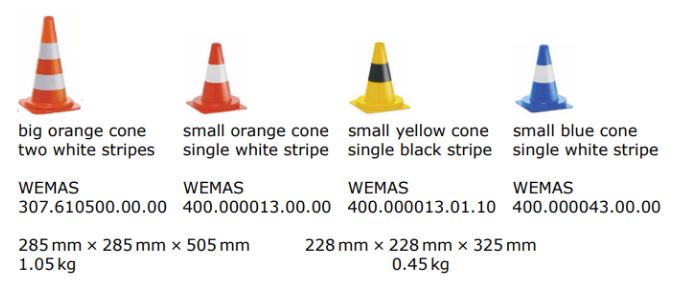
As you can see each cone has a layered architecture. With Blue and orange cones have a white band in the middle while the yellow cone has a black band in the middle. It seems that based on this data the network should be able to discriminate per cone type based on the intensities and the structure.

# Step 6: distribution of number of points over distance and cone type

In [14]:
bins = [10, 20, 30]

number_of_points_per_type_and_distance = {bin : {
    1: {"n_points": [], "distance": []},
    2: {"n_points": [], "distance": []},
    3: {"n_points": [], "distance": []},
    255: {"n_points": [], "distance": []},
} for bin in bins}

In [15]:
import math
def distance(x, y, z):
    return math.sqrt(x**2 + y**2 + z**2)

for cluster in clusters:
    label = cluster["label"]
    if label == 0:
        continue
    centroid = cluster["mean"]
    n_points = cluster["points_length"]
    dist = distance(centroid["x"], centroid["y"], centroid["z"])
    bin = 10
    if dist > 10:
        bin = 20
    if dist > 20:
        bin = 30
    
    number_of_points_per_type_and_distance[bin][label]["n_points"].append(n_points)
    number_of_points_per_type_and_distance[bin][label]["distance"].append(dist)

In [16]:

!pip install "numpy<2" --force-reinstall


  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas 2.0.3 requires pytz>=2020.1, which is not installed.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, which is not installed.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, which is not installed.
numba 0.55.2 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.
scipy 1.9.3 requires numpy<1.26.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.


In [17]:
! pip install matplotlib==3.7.2 ipython==8.15 jupyterlab==4.1


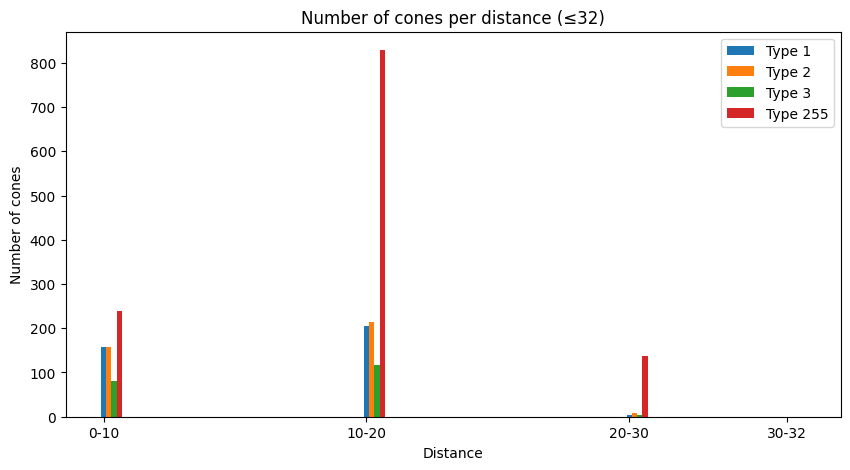

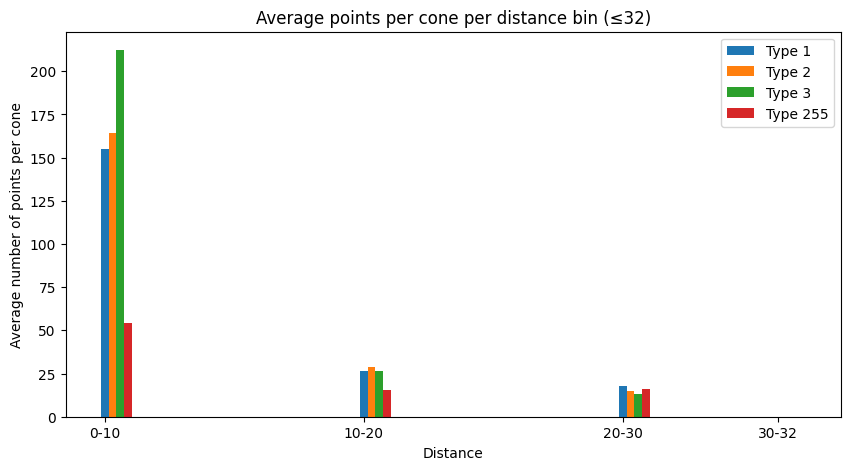

In [22]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt

types = [1, 2, 3, 255]

# Gather all cones per type into lists
data_per_type = {t: {"distance": [], "n_points": []} for t in types}

for b, type_dict in number_of_points_per_type_and_distance.items():
    for t in types:
        distances = type_dict[t]["distance"]
        n_points = type_dict[t]["n_points"]
        data_per_type[t]["distance"].extend(distances)
        data_per_type[t]["n_points"].extend(n_points)

# Define bins up to 32
bins = [0, 10, 20, 30, 32]
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
bar_width = 0.2  # width for first plot bars

# 1️⃣ Number of cones per distance bin (side-by-side bars)
plt.figure(figsize=(10,5))
for i, t in enumerate(types):
    counts_per_bin = []
    for j in range(len(bins)-1):
        count = sum(1 for d in data_per_type[t]["distance"] if bins[j] < d <= bins[j+1])
        counts_per_bin.append(count)
    plt.bar([x + i*bar_width for x in bin_centers], counts_per_bin, width=bar_width, label=f"Type {t}")

plt.xlabel("Distance")
plt.ylabel("Number of cones")
plt.title("Number of cones per distance (≤32)")
plt.xticks(bin_centers, [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)])
plt.legend()
plt.show()

# 2️⃣ Average number of points per cone per distance bin (wider bars)
plt.figure(figsize=(10,5))
bar_width_avg = 0.3  # wider bars
for i, t in enumerate(types):
    avg_points_per_bin = []
    for j in range(len(bins)-1):
        points_in_bin = [n for n, d in zip(data_per_type[t]["n_points"], data_per_type[t]["distance"])
                         if bins[j] < d <= bins[j+1]]
        if points_in_bin:
            avg_points_per_bin.append(sum(points_in_bin)/len(points_in_bin))
        else:
            avg_points_per_bin.append(0)
    plt.bar([x + i*bar_width_avg for x in bin_centers], avg_points_per_bin, width=bar_width_avg, label=f"Type {t}")

plt.xlabel("Distance")
plt.ylabel("Average number of points per cone")
plt.title("Average points per cone per distance bin (≤32)")
plt.xticks(bin_centers, [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)])
plt.legend()
plt.show()


TODO: write analysis